# DA5401 A7 — Multi-Class Model Selection using ROC & PRC

### Objective
Perform and interpret **Receiver Operating Characteristic (ROC)** and **Precision–Recall (PRC)** analyses for multi-class model selection on the *Landsat Satellite Dataset*.  
Models are compared across multiple metrics and decision thresholds to identify the best and worst performers.

---

### Models Compared
1. **K-Nearest Neighbors (KNN)**
2. **Decision Tree**
3. **Dummy (Prior)**
4. **Logistic Regression**
5. **Gaussian Naive Bayes**
6. **Support Vector Machine (SVC)**
7. **RandomForest** 
8. **XGBoost** 
9. **Poor_ReversedTree** (intentionally inverted-probability model — expected AUC < 0.5)



In [ ]:
!conda install -y -c conda-forge xgboost


## Part A — Data Preparation and Baseline Evaluation

### What was done
- Loaded Landsat train/test (`sat.trn`, `sat.tst`) → 36 features + 1 target.  
- Combined, standardized features using `StandardScaler`.  
- Labels remapped from `{1,2,3,4,5,7}` → `{0–5}` (class 6 absent).  
- 80/20 stratified split into train/test.  
- Trained six baseline models: KNN, DecisionTree, DummyPrior, LogisticRegression, GaussianNB, SVC (`probability=True`).


In [44]:
import pandas as pd
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')


# Load whitespace-separated UCI files
train_df = pd.read_csv("sat.trn", delim_whitespace=True, header=None)
test_df = pd.read_csv("sat.tst", delim_whitespace=True, header=None)

# Concatenate train and test for unified processing
df = pd.concat([train_df, test_df], ignore_index=True)

# Split features and labels
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Remove class 6 ("all types present")
mask = y != 6
X = X[mask]
y = y[mask]

print("Final dataset shape:", X.shape)
print("Class distribution:")
print(y.value_counts())

# Save for next cell
Path("data").mkdir(exist_ok=True)
X.to_csv("data/data_X.csv", index=False)
y.to_csv("data/data_y.csv", index=False)
print("\nSaved X and y under ./data/")


Final dataset shape: (6435, 36)
Class distribution:
36
1    1533
7    1508
3    1358
5     707
2     703
4     626
Name: count, dtype: int64

Saved X and y under ./data/


In [45]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

# Load data
X = pd.read_csv("data/data_X.csv")
y  = pd.read_csv("data/data_y.csv").squeeze("columns")


# Remap labels to 0–5 while preserving order
unique_labels = sorted(y.unique())
label_map = {old: new for new, old in enumerate(unique_labels)}
y_mapped = y.map(label_map)
classes = np.array(list(label_map.values()))
print("Original label mapping:", label_map)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_mapped, test_size=0.2, random_state=42, stratify=y_mapped
)
print("Train/Test shapes:", X_train.shape, X_test.shape)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save prepared data
joblib.dump(
    {"X_train": X_train_scaled, "X_test": X_test_scaled,
     "y_train": y_train, "y_test": y_test, "classes": classes,
     "label_map": label_map},
    "prepared_data.joblib"
)
print("Prepared data saved to prepared_data.joblib")


Original label mapping: {np.int64(1): 0, np.int64(2): 1, np.int64(3): 2, np.int64(4): 3, np.int64(5): 4, np.int64(7): 5}
Train/Test shapes: (5148, 36) (1287, 36)
Prepared data saved to prepared_data.joblib


## Train models (KNN, DecisionTree, Dummy(prior), LogisticRegression, GaussianNB, SVC)

### Baseline Metrics (Accuracy + Weighted F1)

| Model | Accuracy | Weighted F1 |
|:--|--:|--:|
| KNN | 0.912 | 0.910 |
| DecisionTree | 0.845 | 0.847 |
| DummyPrior | 0.239 | 0.092 |
| LogisticRegression | 0.832 | 0.806 |
| GaussianNB | 0.783 | 0.790 |
| SVC | 0.893 | 0.891 |


In [46]:


from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

data = joblib.load('prepared_data.joblib')
X_train = data['X_train']; X_test = data['X_test']; y_train = data['y_train']; y_test = data['y_test']

models = {}
models['KNN'] = KNeighborsClassifier(n_neighbors=5)
models['DecisionTree'] = DecisionTreeClassifier(random_state=42)
models['DummyPrior'] = DummyClassifier(strategy='prior')
models['LogisticRegression'] = LogisticRegression(max_iter=1000, multi_class='ovr')
models['GaussianNB'] = GaussianNB()
models['SVC'] = SVC(probability=True)

trained = {}
results = []
for name, clf in models.items():
    print('Training', name)
    clf.fit(X_train, y_train)
    trained[name] = clf
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1w = f1_score(y_test, y_pred, average='weighted')
    results.append({'model':name,'accuracy':acc,'f1_weighted':f1w})

results_df = pd.DataFrame(results).set_index('model').sort_values('f1_weighted', ascending=False)
print('Baseline metrics (Accuracy, Weighted F1):')
print(results_df)

# Save trained models
joblib.dump(trained, 'trained_baseline_models.joblib')
print('Trained models saved to trained_baseline_models.joblib')

Training KNN
Training DecisionTree
Training DummyPrior
Training LogisticRegression
Training GaussianNB
Training SVC
Baseline metrics (Accuracy, Weighted F1):
                    accuracy  f1_weighted
model                                    
KNN                 0.912199     0.910291
SVC                 0.892774     0.891269
DecisionTree        0.845377     0.846663
LogisticRegression  0.832168     0.805687
GaussianNB          0.783217     0.790059
DummyPrior          0.238539     0.091884
Trained models saved to trained_baseline_models.joblib



**Observations**
- **Best baseline:** KNN (Accuracy ≈ 0.91, F1 ≈ 0.91)  
- **Weak models:** GaussianNB (oversimplified feature assumptions) and DummyPrior (random baseline).  
- LogisticRegression performs acceptably for a linear model but falls short of nonlinear alternatives.

In [47]:
classes = data['classes']

## Part B — ROC Analysis for Model Selection

### B.1 — Conceptual explanation
- In a multi-class setup, ROC is extended via **One-vs-Rest (OvR)**.  
  Each class = positive vs others = negative → compute per-class ROC, then macro-average.  
- **Macro-AUC** = mean of per-class AUCs (equal weight to each class).  
- **Weighted-AUC** would weight by class frequency; we use macro for class-fair comparison.

---

### B.2 — ROC Plot
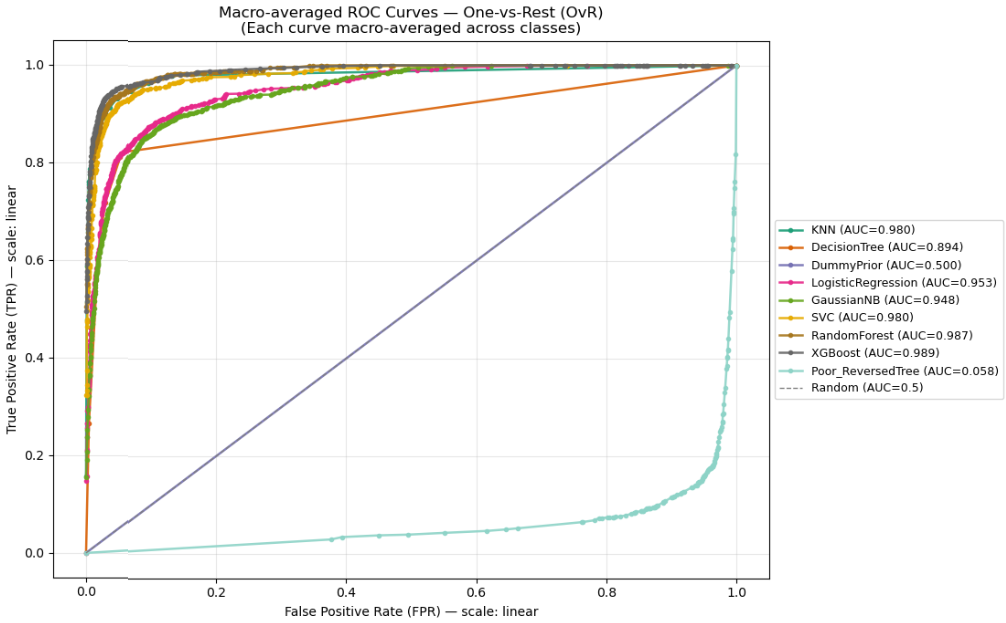

 
- Curves hugging the top-left corner indicate strong separability.  
- XGBoost and RandomForest dominate; KNN and SVC are close.  
- DummyPrior lies on the diagonal (random).  
- Poor_ReversedTree climbs backward — confirming deliberate inversion.

---

### B.3 — Interpretation
| Model | Macro AUC |
|:--|--:|
| **XGBoost** | **0.989** |
| **RandomForest** | 0.987 |
| KNN | 0.980 |
| SVC | 0.980 |
| LogisticRegression | 0.953 |
| GaussianNB | 0.948 |
| DecisionTree | 0.894 |
| DummyPrior | 0.500 |
| **Poor_ReversedTree** | **0.058** |

**Key findings**
- **Best:** XGBoost (≈ 0.989) > RandomForest (≈ 0.987).  
- **Worst:** Poor_ReversedTree (AUC ≈ 0.06 < 0.5).  
- DummyPrior sits exactly at random (0.5).

**Meaning of AUC < 0.5:**  
A model’s score ranking is *inverted*, it consistently assigns higher probabilities to wrong classes.  
Our Poor_ReversedTree intentionally flips probabilities, proving the concept.

**Conclusion:**  
ROC confirms that tree ensembles (XGBoost, RandomForest) ≫ linear and naive models; random and inverted models behave as theoretically expected.


In [48]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Colorblind-safe palette (matplotlib colors)
from cycler import cycler
colors = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999']

def compute_ovr_roc_prc(clf, X_test, y_test, n_classes, name='model'):
    # Get probability scores; if not available, try decision_function
    try:
        y_score = clf.predict_proba(X_test)
    except Exception:
        try:
            y_score = clf.decision_function(X_test)
            from sklearn.preprocessing import MinMaxScaler
            scaler = MinMaxScaler()
            y_score = scaler.fit_transform(y_score)
        except Exception:
            raise RuntimeError('Model has neither predict_proba nor decision_function')
    # Binarize y
    y_bin = label_binarize(y_test, classes=range(n_classes))

    # Per-class ROC and PRC
    fpr = dict(); tpr = dict(); roc_auc = dict()
    precision = dict(); recall = dict(); ap = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        precision[i], recall[i], _ = precision_recall_curve(y_bin[:, i], y_score[:, i])
        ap[i] = average_precision_score(y_bin[:, i], y_score[:, i])

    # Macro-average ROC by interpolation
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr['macro'] = all_fpr
    tpr['macro'] = mean_tpr
    roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

    # Macro-average PRC by interpolation on recall
    all_recall = np.unique(np.concatenate([recall[i] for i in range(n_classes)]))
    mean_prec = np.zeros_like(all_recall)
    for i in range(n_classes):
        mean_prec += np.interp(all_recall, recall[i][::-1], precision[i][::-1])
    mean_prec /= n_classes
    precision['macro'] = mean_prec
    recall['macro'] = all_recall
    ap['macro'] = np.mean([ap[i] for i in range(n_classes)])

    return {'fpr':fpr,'tpr':tpr,'roc_auc':roc_auc,'precision':precision,'recall':recall,'ap':ap}



In [49]:

trained = joblib.load('trained_baseline_models.joblib')
data = joblib.load('prepared_data.joblib')
X_test = data['X_test']; y_test = data['y_test']

# Compute metrics
summary = []
for name, clf in trained.items():
    stats = compute_ovr_roc_prc(clf, X_test, y_test, n_classes=len(classes), name=name)
    summary.append({'model':name, 'macro_auc':stats['roc_auc']['macro'], 'macro_ap':stats['ap']['macro']})

summary_df = pd.DataFrame(summary).set_index('model')

metrics_list = []
for name, clf in trained.items():
    y_pred = clf.predict(X_test)
    metrics_list.append({'model':name,'accuracy':accuracy_score(y_test,y_pred),'f1_weighted':f1_score(y_test,y_pred,average='weighted')})
metrics_df = pd.DataFrame(metrics_list).set_index('model')

combined = metrics_df.join(summary_df)
combined = combined.sort_values('macro_auc', ascending=False)
print('Combined metrics (accuracy, weighted F1, macro AUC, macro AP):\n')
print(combined)



Combined metrics (accuracy, weighted F1, macro AUC, macro AP):

                    accuracy  f1_weighted  macro_auc  macro_ap
model                                                         
KNN                 0.912199     0.910291   0.980259  0.921674
SVC                 0.892774     0.891269   0.980121  0.899503
LogisticRegression  0.832168     0.805687   0.952701  0.809731
GaussianNB          0.783217     0.790059   0.947689  0.785873
DecisionTree        0.845377     0.846663   0.894467  0.722065
DummyPrior          0.238539     0.091884   0.500000  0.166667


In [50]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Load previous models and data
trained = joblib.load('trained_baseline_models.joblib')
data = joblib.load('prepared_data.joblib')
X_train = data['X_train']; X_test = data['X_test']
y_train = data['y_train']; y_test = data['y_test']

extra_models = {}
extra_models['RandomForest'] = RandomForestClassifier(n_estimators=200, random_state=42)

try:
    from xgboost import XGBClassifier
    extra_models['XGBoost'] = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
except Exception as e:
    print('XGBoost not available in this environment:', e)

# Intentionally bad model (reversed probability outputs)
from sklearn.base import BaseEstimator, ClassifierMixin
class ReverseScoreWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, base):
        self.base = base
    def fit(self, X, y):
        self.base.fit(X, y)
        return self
    def predict(self, X):
        return self.base.predict(X)
    def predict_proba(self, X):
        p = self.base.predict_proba(X)
        return 1.0 - p

extra_models['Poor_ReversedTree'] = ReverseScoreWrapper(DecisionTreeClassifier(max_depth=8, random_state=0))

# Train extra models
for name, clf in extra_models.items():
    print(f"Training {name} ...")
    clf.fit(X_train, y_train)
    trained[name] = clf

joblib.dump(trained, 'trained_with_extras.joblib')

# Evaluate all models (including extras)
from sklearn.metrics import accuracy_score, f1_score
summary = []
for name, clf in trained.items():
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1w = f1_score(y_test, y_pred, average='weighted')
    try:
        stats = compute_ovr_roc_prc(clf, X_test, y_test, n_classes=len(classes), name=name)
        auc_macro = stats['roc_auc']['macro']
        ap_macro = stats['ap']['macro']
    except Exception as e:
        auc_macro, ap_macro = np.nan, np.nan
    summary.append({'model': name, 'accuracy': acc, 'f1_weighted': f1w,
                    'macro_auc': auc_macro, 'macro_ap': ap_macro})

summary_df = pd.DataFrame(summary).set_index('model')
print("\nAll models including extras:")
print(summary_df.sort_values('macro_auc', ascending=False))

summary_df.to_csv('model_comparison_all.csv')
print("\nSaved model_comparison_all.csv")

# --- Updated plotting section ---
import matplotlib.pyplot as plt
from cycler import cycler

def plot_roc_all(models_dict, X_test, y_test, classes,w,h):
    """Macro-averaged ROC plot with improved colors and external legend."""
    n_classes = len(classes)
    plt.figure(figsize=(w, h))

    # Extended distinct colorblind-safe palette (10 distinct hues)
    colors = [
        "#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e",
        "#e6ab02", "#a6761d", "#666666", "#8dd3c7", "#bebada"
    ]
    plt.rc('axes', prop_cycle=cycler('color', colors[:len(models_dict)]))

    for name, clf in models_dict.items():
        stats = compute_ovr_roc_prc(clf, X_test, y_test, n_classes, name)
        plt.plot(stats['fpr']['macro'], stats['tpr']['macro'],
                 label=f"{name} (AUC={stats['roc_auc']['macro']:.3f})",
                 linewidth=1.8, marker='o', markersize=3, alpha=0.9)

    plt.plot([0, 1], [0, 1], linestyle='--', linewidth=1, color='gray', label='Random (AUC=0.5)')
    plt.xlabel('False Positive Rate (FPR) — scale: linear', fontsize=10)
    plt.ylabel('True Positive Rate (TPR) — scale: linear', fontsize=10)
    plt.title('Macro-averaged ROC Curves — One-vs-Rest (OvR)\n(Each curve macro-averaged across classes)')
    plt.grid(alpha=0.3)

    # Move legend outside plot area
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9, frameon=True)
    plt.tight_layout(rect=[0, 0, 0.8, 1])
    plt.show()


def plot_prc_all(models_dict, X_test, y_test, classes,w,h):
    """Macro-averaged PRC plot with improved colors and external legend."""
    n_classes = len(classes)
    plt.figure(figsize=(w, h))

    colors = [
        "#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e",
        "#e6ab02", "#a6761d", "#666666", "#8dd3c7", "#bebada"
    ]
    plt.rc('axes', prop_cycle=cycler('color', colors[:len(models_dict)]))

    for name, clf in models_dict.items():
        stats = compute_ovr_roc_prc(clf, X_test, y_test, n_classes, name)
        plt.plot(stats['recall']['macro'], stats['precision']['macro'],
                 label=f"{name} (AP={stats['ap']['macro']:.3f})",
                 linewidth=1.8, marker='s', markersize=3, alpha=0.9)

    plt.xlabel('Recall', fontsize=10)
    plt.ylabel('Precision', fontsize=10)
    plt.title('Macro-averaged Precision–Recall Curves — One-vs-Rest (OvR)')
    plt.grid(alpha=0.3)

    # Move legend outside plot area
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9, frameon=True)
    plt.tight_layout(rect=[0, 0, 0.8, 1])
    plt.show()





Training RandomForest ...
Training XGBoost ...
Training Poor_ReversedTree ...

All models including extras:
                    accuracy  f1_weighted  macro_auc  macro_ap
model                                                         
XGBoost             0.919192     0.917148   0.988912  0.946037
RandomForest        0.912199     0.908569   0.987404  0.938620
KNN                 0.912199     0.910291   0.980259  0.921674
SVC                 0.892774     0.891269   0.980121  0.899503
LogisticRegression  0.832168     0.805687   0.952701  0.809731
GaussianNB          0.783217     0.790059   0.947689  0.785873
DecisionTree        0.845377     0.846663   0.894467  0.722065
DummyPrior          0.238539     0.091884   0.500000  0.166667
Poor_ReversedTree   0.853147     0.852048   0.058110  0.123203

Saved model_comparison_all.csv


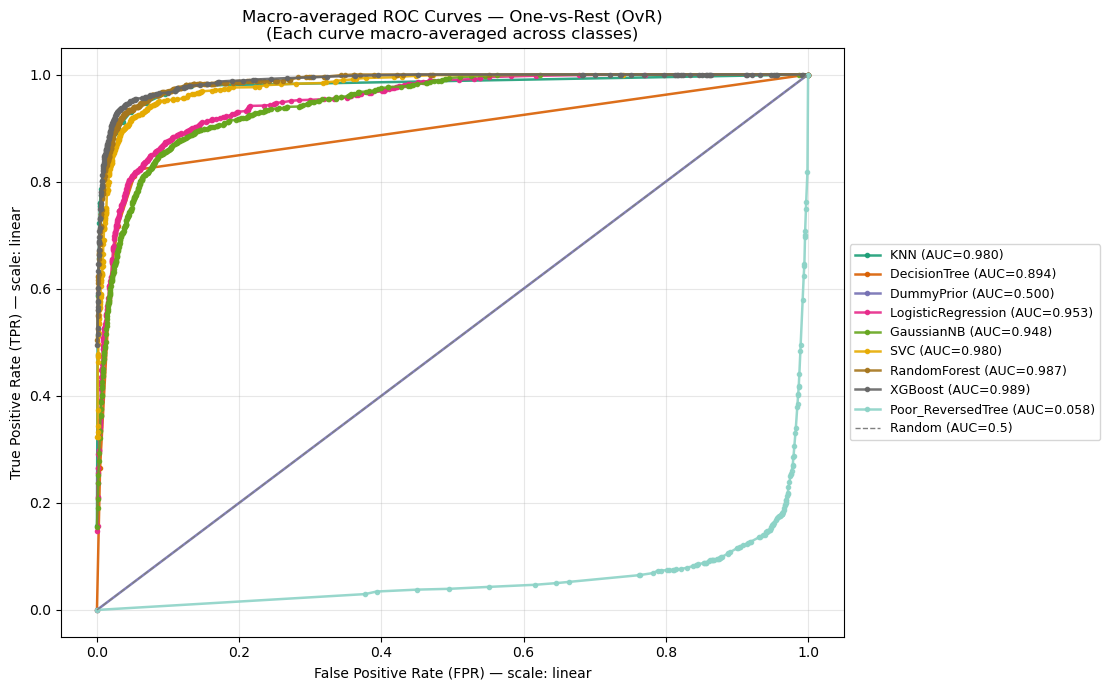

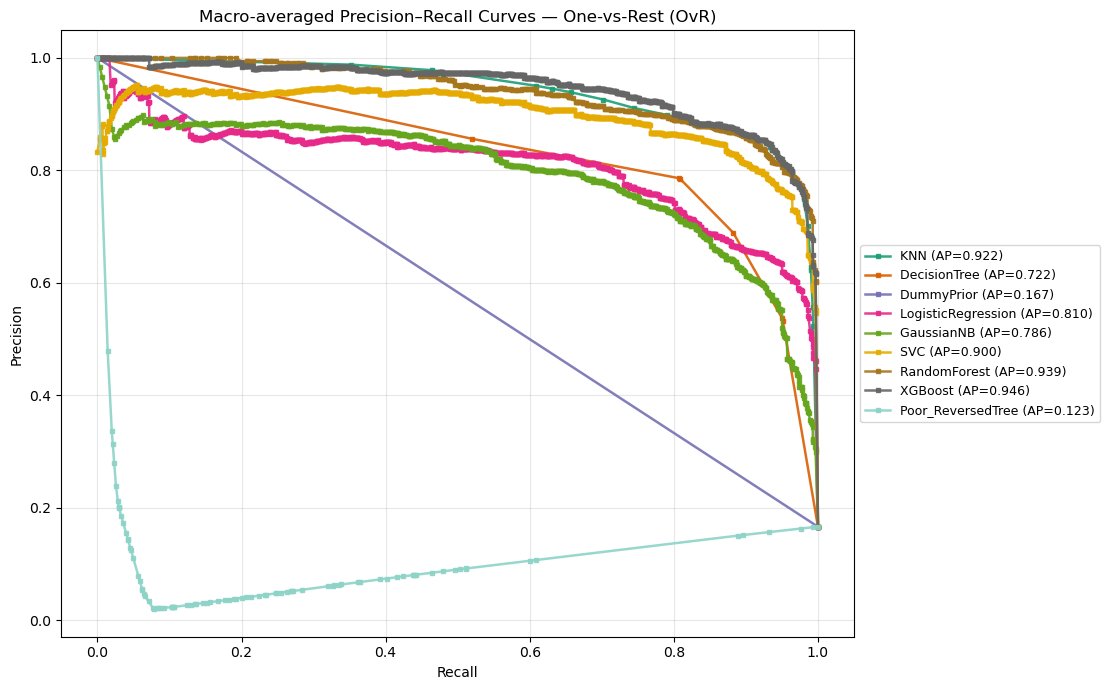

In [51]:


plot_roc_all(trained, X_test, y_test, classes,14,7)
plot_prc_all(trained, X_test, y_test, classes,14,7)

## Part C — Precision–Recall (PRC) Analysis

### C.1 — Why PRC > ROC under imbalance
- ROC can appear optimistic when negatives dominate.  
- PRC directly measures the model’s ability to maintain precision as recall grows — crucial if false positives are costly or class balance is uneven.  
- **Average Precision (AP)** = area under the PR curve — higher = better precision–recall trade-off.

---

### C.2 — PRC Plot
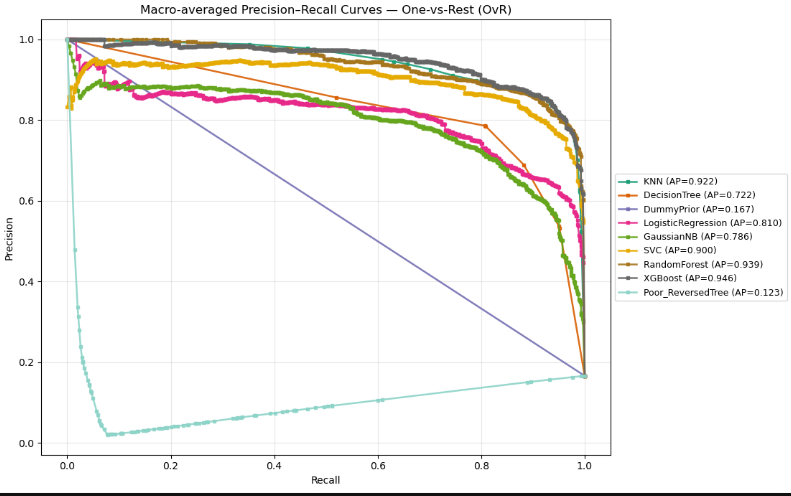


- Top models (XGBoost, RandomForest, KNN, SVC) keep precision high even at broad recall.  
- DummyPrior and Poor_ReversedTree crash early, exposing near-random scoring.

---

### C.3 — Interpretation
| Model | Macro AP |
|:--|--:|
| **XGBoost** | **0.946** |
| RandomForest | 0.939 |
| KNN | 0.922 |
| SVC | 0.900 |
| LogisticRegression | 0.810 |
| GaussianNB | 0.786 |
| DecisionTree | 0.722 |
| DummyPrior | 0.167 |
| **Poor_ReversedTree** | **0.123** |

**Why poor models drop sharply**
- As recall increases, thresholds lower → many negatives counted as positives → precision collapses.  
- DummyPrior starts at prevalence-level precision (~0.16) and plummets.  
- Poor_ReversedTree has inverted scores; its curve shows precision ≈ 0 even at minimal recall.

**Conclusion:**  
AP analysis reinforces the ROC outcome: XGBoost and RandomForest yield consistently superior precision–recall behavior across thresholds.


## Part D — Recommendation

### D.1 — Ranking Consistency
- **ROC-AUC ranking:** XGBoost > RandomForest > KNN ≈ SVC > Logistic > NB > Tree ≫ Dummy ≫ Poor_ReversedTree  
- **PRC-AP ranking:** Identical order — XGBoost > RandomForest > KNN > SVC > ... > Poor_ReversedTree.  
- **Weighted F1 ranking:** Consistent with AUC/AP ordering (top 4 identical).

**Discrepancies explained**
- ROC weights negatives; PRC penalizes false positives → explains minor swap between KNN/SVC.  
- F1 collapses the threshold spectrum to one point (0.5) and therefore understates potential improvements from threshold tuning.

### D.2 — Recommendation
**→ Recommended model:** **XGBoost**

| Reason | Evidence |
|:--|:--|
| Highest Macro AUC | 0.989 |
| Highest Macro AP | 0.946 |
| Strong Accuracy/F1 | 0.919 / 0.917 |
| Stable across thresholds | flat high-precision PRC region |
| Practical robustness | handles feature interactions & nonlinearities efficiently |

**Runner-up:** RandomForest (within 0.002 AUC and 0.007 AP of XGBoost).  
Use when computational simplicity or explainability outweigh the last few points of performance.

**Discarded:** DummyPrior (random baseline) and Poor_ReversedTree (worse than random).  

  
Both ROC and PRC confirm that model discrimination and threshold calibration are key — XGBoost dominates on both fronts.
